In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

In [3]:
from ditb.io.imread import mmzarr_read
from ditb.io.metadata import read_mmzarr_metadata, get_tile_coordinate, get_imshape, get_imtype, get_pixel_size, list_images, get_channel_names
from functools import partial


In [3]:
test_data = '../../Notebooks/Est_map_40x_2_normalized.zarr/'
#test_data = '../../Notebooks/corrected_white/' #  DW corrected
metadata = read_mmzarr_metadata(test_data)
img_tiles = mmzarr_read(test_data)
img_tiles

dask.array<stack, shape=(42, 1, 6, 1, 512, 512), dtype=uint16, chunksize=(1, 1, 1, 1, 512, 512), chunktype=numpy.ndarray>

In [4]:
from shapely.geometry.base import BaseGeometry
from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString
from typing import List, Callable, Union
import numpy as np 

def get_tile_corners(width:int, height:int, transform:Union[None, np.array]=None) -> np.array:
    """
    Create the corners of the rectangle define by width and height.
    If transform is given apply this transform matrix to the rectangle 
    corners.
    """

    rect = np.array(((0,0), (height, 0), 
                     (height, width), 
                     (0,width)))
    
    if transform is not None:
        fake_z = np.concatenate((rect, np.ones((rect.shape[0],1))), axis=1)
        # Remove the fake Z of the transformer corners
        rect = (transform @ fake_z.T).T[:, :-1]
        
    return rect

def numpy_shape_to_shapely(coords: np.ndarray, shape_type: str = "polygon") -> BaseGeometry:
    """
    Convert an individual shape represented as a numpy array of coordinates
    to a shapely object
    """
    _coords = coords[:, ::-1].copy()  # shapely has col,row order, numpy row,col
    _coords[:, 1] *= -1  # axis direction flipped between shapely and napari
    if shape_type in ("rectangle", "polygon", "ellipse"):
        return Polygon(_coords)
    elif shape_type in ("line", "path"):
        return LineString(_coords)
    else:
        raise ValueError

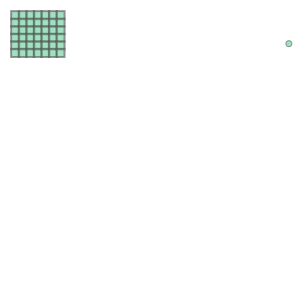

In [71]:
from skimage.transform import AffineTransform
from shapely.geometry import GeometryCollection, Point

w, h = get_imshape(metadata)
pixum = get_pixel_size(metadata)
img_names = list_images(metadata)
coordinates = np.stack([get_tile_coordinate(tile, metadata) for tile in img_names])
transforms = [AffineTransform(translation=pos[::-1]/pixum).params for pos in coordinates]
tiles = [get_tile_corners(w, h, t) for t in transforms]
tiles_shapely = [numpy_shape_to_shapely(t) for t in tiles]

origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shapely)))

In [72]:
# Determine the size of all those tiles
all_bboxes = np.vstack(tiles)
all_min = all_bboxes.min(axis=0)
all_max = all_bboxes.max(axis=0)

stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
print(f'Mosaic size {stitched_shape}')

# Create a new transform to offset the origin to minimum position of tiles
shift_to_origin = AffineTransform(translation=-all_min)
transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
shifted_tiles = [get_tile_corners(w, h, t) for t in transforms_with_shift]

Mosaic size (2886, 3365)


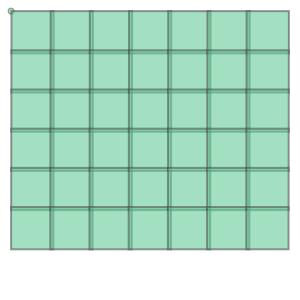

In [73]:
tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
origin = Point(0,0)
GeometryCollection((origin, GeometryCollection(tiles_shifted_shapely)))

In [8]:
get_tile_coordinate(img_names[0], metadata)

(-4924.625796896424, -577.1758851267496)

### Build the mosaic array that will stich each pos

In [5]:
from typing import Dict, List, Tuple

import numpy as np
from dask.array.core import normalize_chunks
from shapely.strtree import STRtree
from dask.array.core import normalize_chunks
from scipy.ndimage import affine_transform
from skimage.io import imread
from skimage.transform import AffineTransform
import dask
import zarr
from dask.diagnostics import ProgressBar

def get_chunk_coordinates(shape: Tuple[int, int], chunk_size: Tuple[int, int]):
    """Iterator that returns the bounding coordinates
    for the individual chunks of a dask array of size
    shape with chunk size chunk_size.
    return_np_slice determines the output format. If True,
    a numpy slice object is returned for each chunk, that can be used
    directly to slice a dask array to return the desired chunk region.
    If False, a Tuple of Tuples ((row_min, row_max+1),(col_min, col_max+1))
    is returned.
    """
    chunksy, chunksx = normalize_chunks(chunk_size, shape=shape)
    y = 0
    for cy in chunksy:
        x = 0
        for cx in chunksx:
            yield ((y, y + cy), (x, x + cx))
            x = x + cx
        y = y + cy

        
def get_chunk_coordinates2(chunksy, chunksx):
    y = 0
    for cy in chunksy:
        x = 0
        for cx in chunksx:
            yield ((y, y + cy), (x, x + cx))
            x = x + cx
        y = y + cy
        
        
def get_rect_from_chunk_boundary(chunk_boundary):
    """given a chunk boundary tuple, return a numpy
    array that can be added as a shape to napari"
    """
    ylim, xlim = chunk_boundary
    miny, maxy = ylim[0], ylim[1] - 1
    minx, maxx = xlim[0], xlim[1] - 1
    return np.array([[miny, minx], [maxy, minx], [maxy, maxx], [miny, maxx]])


def find_chunk_tile_intersections(
    tiles_infos: list[dict['shapely polygone', 'dask image', 'affine transform']],
    chunks_infos: list[dict['shapely polygone', 'chunk boundaries']],
    ) -> Dict[Tuple[int, int], Tuple[str, np.ndarray]]:
    """
    For each large chunk find tiles whithin this chunk and return a list with the 
    dask lazy image and transform for each tile in that chunks.
    
    Parameters:
    -----------
    tiles_infos, list of dict: 
        Contains list of tile defined as a dict and the dict should have the following keys:
        'shapely': Contains the shapely objects corresponding to transformed tile outlines.
        'lazy_image': The dask object for the given tile
        'transform': The transform matrix for this tile (including shift to origin)
        
    chunks_infos, list of dict: 
        Contains list of final chunks (large tiles) defined as a dict and the dict should have 
        the following keys:
        'shapely': Contains the shapely objects representing dask array chunks.
        'chunk_boundary': containing a tuple of chunk boundaries
        
    Returns:
    --------
         The chunk_to_tiles dictionary, which has the chunk anchor points as keys and tuples of
         image file names and their corresponding affine transform matrix as values.
    """
    chunk_to_tiles = {}
    tile_tree = STRtree([t['shapely'] for t in tiles_infos])

    for chunk in chunks_infos:
        chunk_boundary = chunk["chunk_boundary"]
        anchor_point = (chunk_boundary[0][0], chunk_boundary[1][0])
        intersecting_tiles = tile_tree.query(chunk['shapely'])
        chunk_to_tiles[anchor_point] = [
            ((tiles_infos[t]["lazy_image"], tiles_infos[t]["transform"]))
            for t in intersecting_tiles
        ]
    return chunk_to_tiles


def fuse_func(
    input_tile_info: Dict[
        Tuple[int, int], List[Tuple[dask.array, np.ndarray]]
    ],
    load_tile_func=None,
    block_info=None,
    dtype=np.uint16,
) -> np.ndarray:

    """
    Fuses the tiles that intersect the current chunk of a dask array using maximum projection.
    Pass this function to dask.array.map_blocks, after partial evaluation of the required
    image_folder and (if needed) optional arguments.
    Returns:
        Array of chunk-shape containing max projection of tiles falling into chunk
    """
    array_location = block_info[None]["array-location"]
    # The anchor point is the key to the input_tile_info dictionary
    anchor_point = (array_location[0][0], array_location[1][0])
    chunk_shape = block_info[None]["chunk-shape"]
    tiles_info = input_tile_info[anchor_point]
    print(f"Processing chunk at {anchor_point}")
    fused = np.zeros(chunk_shape, dtype=dtype)
    # print(tiles_info)
    for image_representation, tile_affine in tiles_info:
        #print(type(image_representation))
        if load_tile_func is not None:
            im = load_tile_func(**image_representation)
        else:
            im = image_representation
        #print(type(im), tile_affine)
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(
            im,
            matrix=np.linalg.inv(shift.params @ tile_affine),
            output_shape=chunk_shape,
            cval=0,
        )
        # note that the dtype comversion here happens without scaling
        # may want to use one of the skimage.img_as_* functions instead
        stack = np.stack([fused, tile_shifted])
        fused = np.max(stack, axis=0)
    return fused


def mmzarr_load_one_tile(zarr_path: str, roi=1, tile=0, time=0, channel=0, z=0) -> dask.array:
    """
    Load only one image for the MMzarr file structure
    """
    
    component = f'Roi:{roi}/Tile:{tile}/0'
    return dask.array.from_zarr(zarr_path, component=component)[time, channel, z]

In [93]:
mosaic_chunk_size = (1024, 1024)
chunks = normalize_chunks(mosaic_chunk_size, shape=stitched_shape)
print(chunks)
chunk_boundaries = list(get_chunk_coordinates(stitched_shape, mosaic_chunk_size))

((1024, 1024, 838), (1024, 1024, 1024, 293))


In [102]:
nx, ny = np.ceil(np.array(stitched_shape) / (mosaic_chunk_size)).astype(int)
chunks = ((mosaic_chunk_size[0],)*nx, (mosaic_chunk_size[1],)*ny)
print(chunks)
chunk_boundaries = list(get_chunk_coordinates2(*chunks))
print(chunk_boundaries)

((1024, 1024, 1024), (1024, 1024, 1024, 1024))
[((0, 1024), (0, 1024)), ((0, 1024), (1024, 2048)), ((0, 1024), (2048, 3072)), ((0, 1024), (3072, 4096)), ((1024, 2048), (0, 1024)), ((1024, 2048), (1024, 2048)), ((1024, 2048), (2048, 3072)), ((1024, 2048), (3072, 4096)), ((2048, 3072), (0, 1024)), ((2048, 3072), (1024, 2048)), ((2048, 3072), (2048, 3072)), ((2048, 3072), (3072, 4096))]


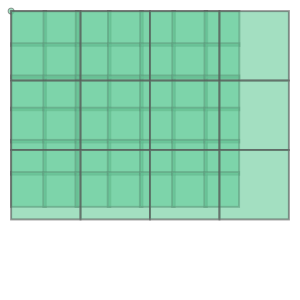

In [103]:
chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]

GeometryCollection([origin, 
                    GeometryCollection(tiles_shifted_shapely), 
                    GeometryCollection(chunks_shapely),])

In [104]:
img_tiles

dask.array<stack, shape=(42, 1, 6, 1, 512, 512), dtype=uint16, chunksize=(1, 1, 1, 1, 512, 512), chunktype=numpy.ndarray>

In [105]:
# Loop over shapely tiles to attach the transform matrix to them and the tile image object
tiles_infos = []
im_filter = 5
cpt = 0
for tile_shifted_shapely, tile_dask_object, transform in zip(tiles_shifted_shapely, img_tiles, transforms_with_shift):
    tiles_infos += [{'shapely': tile_shifted_shapely, 
                     'lazy_image': {'zarr_path': '../../Notebooks/Est_map_40x_2_normalized.zarr', 'roi': 1, 'tile': cpt, 'channel': im_filter}, 
                     'transform':transform}]
    cpt += 1
    
    
# Loop over target tiles (large chunks) to add their boundarie informations
large_chunks_infos = []
for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
    large_chunks_infos += [{'shapely': chunk_shapely, 
                            'chunk_boundary': chunk_boundary}]

In [124]:
# Now we need to find intersection of new big tiles and small microscope tiles 
# to loade them only when needed
chunk_tiles = find_chunk_tile_intersections(tiles_infos, large_chunks_infos)

In [106]:
for aa, bb in chunk_tiles[(2048, 3072)]:
    print(aa)

NameError: name 'chunk_tiles' is not defined

In [107]:
type(chunk_tiles[(0,0)][0][0])

NameError: name 'chunk_tiles' is not defined

In [108]:
from functools import partial

_fuse_func=partial(fuse_func, 
                      load_tile_func=mmzarr_load_one_tile,
                      dtype=np.uint8)

res = dask.array.map_blocks(_fuse_func,
                            chunk_tiles,
                            chunks=chunks,
                            dtype=np.uint16)

res

NameError: name 'chunk_tiles' is not defined

In [128]:
mosaic = res.compute()

Processing chunk at (0, 0)Processing chunk at (0, 1024)
Processing chunk at (0, 2048)

Processing chunk at (0, 3072)
Processing chunk at (1024, 0)
Processing chunk at (1024, 1024)
Processing chunk at (1024, 2048)
Processing chunk at (1024, 3072)
Processing chunk at (2048, 0)
Processing chunk at (2048, 1024)
Processing chunk at (2048, 2048)
Processing chunk at (2048, 3072)


In [6]:
from pathlib import Path

def tiles_as_shapely(metadata: dict, selected_tiles: [list, int] = -1):
    """
    Transform micromanager tile coordinates as shapely rectangle 
    """
    
    
    w, h = get_imshape(metadata)
    pixum = get_pixel_size(metadata)
    img_names = np.array(list_images(metadata))
    
    if selected_tiles == -1:
        i_tiles = np.arange(len(img_names))
    else:
        i_tiles = selected_tiles
    
    if not isinstance(i_tiles, np.ndarray):
        i_tiles = np.array(i_tiles)
        
    img_names = img_names[i_tiles]
    coordinates = np.stack([get_tile_coordinate(tile, metadata) for tile in img_names])
    transforms = [AffineTransform(translation=pos[::-1]/pixum).params for pos in coordinates]
    tiles = [get_tile_corners(w, h, t) for t in transforms]
    tiles_shapely = [numpy_shape_to_shapely(t) for t in tiles]
    
    
    # Determine the size of all those tiles
    all_bboxes = np.vstack(tiles)
    all_min = all_bboxes.min(axis=0)
    all_max = all_bboxes.max(axis=0)

    stitched_shape=tuple(np.ceil(all_max-all_min).astype(int))
    print(f'Mosaic size {stitched_shape}')

    # Create a new transform to offset the origin to minimum position of tiles
    shift_to_origin = AffineTransform(translation=-all_min)
    transforms_with_shift = [t @ shift_to_origin.params for t in transforms]
    shifted_tiles = [get_tile_corners(w, h, t) for t in transforms_with_shift]
    tiles_shifted_shapely = [numpy_shape_to_shapely(s) for s in shifted_tiles]
    
    return tiles_shifted_shapely, stitched_shape, transforms_with_shift


def create_mosaic(zarr_file: str, roi: int = -1, channels: [list, int] = -1, mosaic_chunk_size: [int, int] = (1024, 1024),
                  output_file: str = None):
    """
    Stitch tiles together to create a stiched large image saved with as pyramid ome-zarr
    
    Parameters:
    -----------
    
    -1, in roi and channels means all of them.
    
    TODO
    """
    
    
    # Load img_tiles as dask 
    img_tiles = mmzarr_read(zarr_file)
    meta = read_mmzarr_metadata(zarr_file)
    roi_tiles = meta['_roi_tiles']
    
    _fuse_func=partial(fuse_func, 
                       load_tile_func=mmzarr_load_one_tile,
                       dtype=np.uint16)
    
    if roi == -1:
        roi = [int(r.replace('roi', '')) for r in roi_tiles]
    
    if not isinstance(roi, list):
        roi = [roi]
        
    
    channel_names = get_channel_names(meta)
    if channels == -1:    
        channels = np.arange(len(channel_names))
    
    if not isinstance(channels, np.ndarray):
        channels = np.array(channels)
    
    
    # Create the output file
    if output_file is None:
        new_name = f'{str(Path("./")/Path(zarr_file).name.replace(".zarr", ""))}_mosaic.zarr'
    else:
        new_name = output_file
        
    print(f'save to {new_name}')
    # Create a zarr location for the data
    zlocation = parse_url(new_name, 'w')
    root_group = zarr.group(zlocation.store, overwrite=True)
    
    # Define the scaler for pyramid downsampling
    scaler = scale.Scaler()
    scaler.downscale = 2
    scaler.method = 'nearest'
    scaler.max_layer = 4
    
    for r in roi:
        print(f'Stich ROI {r} / {len(roi)}')
        i_tiles = roi_tiles[f'roi{r}']
        
        shapely_tiles, total_size, transforms = tiles_as_shapely(meta, i_tiles)
        chunks = normalize_chunks(mosaic_chunk_size, shape=total_size)
        chunk_boundaries = list(get_chunk_coordinates(total_size, mosaic_chunk_size))
        
        # Version with squared chunks
        #nx, ny = np.ceil(np.array(total_size) / (mosaic_chunk_size)).astype(int)
        #chunks = ((mosaic_chunk_size[0],)*nx, (mosaic_chunk_size[1],)*ny)
        #chunk_boundaries = list(get_chunk_coordinates2(*chunks))

        chunk_shapes = list(map(get_rect_from_chunk_boundary, chunk_boundaries))
        chunks_shapely = [numpy_shape_to_shapely(c) for c in chunk_shapes]
        
        total_mosaic = []
        for ch in channels:
            print(f'Stich channel {channel_names[ch]}')
            # Loop over shapely tiles to attach the transform matrix to them and the tile image object
            tiles_infos = []
            
            for tile_shapely, it, transform in zip(shapely_tiles, i_tiles, transforms):
                if f'Roi:{r}/Tile:{it}' in meta:
                    tiles_infos += [{'shapely': tile_shapely, 
                                     'lazy_image': {'zarr_path': zarr_file, 'roi': r, 'tile': it, 'channel': ch}, 
                                     'transform':transform}]
    
    
            # Loop over target tiles (large chunks) to add their boundarie informations
            large_chunks_infos = []
            for chunk_shapely, chunk_boundary  in zip(chunks_shapely, chunk_boundaries):
                large_chunks_infos += [{'shapely': chunk_shapely, 
                                        'chunk_boundary': chunk_boundary}]
        
        
            # Now we need to find intersection of new big tiles and small microscope tiles 
            # to loade them only when needed
            chunk_tiles = find_chunk_tile_intersections(tiles_infos, large_chunks_infos)
            
            res = dask.array.map_blocks(_fuse_func,
                                        chunk_tiles,
                                        chunks=chunks,
                                        dtype=np.uint16)
            
            total_mosaic += [res]
        
        # Compute and save the mosaic inside a Roi:XX parent group
        roi_group = root_group.create_group(f'Roi:{r}')
        
        with ProgressBar():
            writer.write_image(dask.array.stack(total_mosaic), roi_group, scaler=scaler, axes='cyx')
            
        roi_group.attrs['omero'] = omero_style_metadata(meta, 'test')
    


In [13]:
data_path = '../../Notebooks/sample2_2.zarr'
meta = read_mmzarr_metadata(data_path)
# shapely_tiles, total_size, transforms = tiles_as_shapely(meta)

to_process = create_mosaic(data_path, mosaic_chunk_size=(2048, 2048))

save to sample2_2_mosaic.zarr
Stich ROI 2 / 1
Mosaic size (10509, 18445)
Stich channel DM300_329-351_Fluo
Stich channel DM300_380-420_Fluo
Stich channel DM300_420-480_Fluo
Stich channel DM300_480-550_Fluo
Stich channel DM300_noFilter_Vis
[                                        ] | 0% Completed | 240.41 msProcessing chunk at (0, 0)
Processing chunk at (0, 2048)
Processing chunk at (0, 4096)
Processing chunk at (0, 6144)
Processing chunk at (0, 0)
Processing chunk at (0, 0)
Processing chunk at (0, 0)
Processing chunk at (0, 0)
[                                        ] | 0% Completed | 16.01 smsProcessing chunk at (0, 2048)
[                                        ] | 0% Completed | 16.11 sProcessing chunk at (0, 4096)
[                                        ] | 0% Completed | 16.21 sProcessing chunk at (0, 6144)
[                                        ] | 0% Completed | 16.52 sProcessing chunk at (0, 8192)
[                                        ] | 1% Completed | 16.62 sProcessing 

In [12]:
# roi_tiles = meta['_roi_tiles']
tuple(meta.keys())[0]

'Roi:2/Tile:0'

In [251]:
from ditb.io.metadata import get_roi_name_indices

meta.keys()

dict_keys(['Roi:0/Tile:0', 'Roi:0/Tile:1', 'Roi:0/Tile:2', 'Roi:0/Tile:3', 'Roi:0/Tile:4', 'Roi:0/Tile:5', 'Roi:0/Tile:6', 'Roi:0/Tile:7', 'Roi:0/Tile:8', 'Roi:0/Tile:9', 'Roi:0/Tile:10', 'Roi:0/Tile:11', 'Roi:0/Tile:12', 'Roi:0/Tile:13', 'Roi:0/Tile:14', 'Roi:0/Tile:15', 'Roi:0/Tile:16', 'Roi:0/Tile:17', 'Roi:0/Tile:18', 'Roi:0/Tile:19', 'Roi:0/Tile:20', 'Roi:0/Tile:21', 'Roi:0/Tile:22', 'Roi:0/Tile:23', 'Summary', '_creator', '_roi_tiles'])

In [9]:
from ome_zarr import scale, writer
from ome_zarr.io import parse_url
from pathlib import Path
from ditb.io.metadata import omero_style_metadata

In [59]:
scaler = scale.Scaler()
scaler.downscale = 2
scaler.method = 'laplacian'
scaler.max_layer = 4

output = Path('./test_mosaic.zarr')
store = parse_url(str(output), mode="w").store
root = zarr.group(store=store)
writer.write_image(to_process, root, scaler=scaler, axes='cyx')
root.attrs['omero'] = omero_style_metadata(meta, 'test')

Processing chunk at (0, 0)
Processing chunk at (0, 2048)
Processing chunk at (0, 4096)
Processing chunk at (2048, 0)
Processing chunk at (2048, 2048)
Processing chunk at (2048, 4096)


In [231]:
omero_style_metadata(meta, 'test')

{'id': 1,
 'name': 'test',
 'version': '0.5-dev',
 'channels': [{'active': False,
   'coefficient': 1,
   'color': 'FFFFFF',
   'family': 'linear',
   'inverted': False,
   'label': 'DM300_noFilter_Vis',
   'window': {'end': 5000, 'max': 65535, 'min': 0, 'start': 0}},
  {'active': True,
   'coefficient': 1,
   'color': '6F0092',
   'family': 'linear',
   'inverted': False,
   'label': 'DM300_329-351_Fluo',
   'window': {'end': 5000, 'max': 65535, 'min': 0, 'start': 0}},
  {'active': True,
   'coefficient': 1,
   'color': '6700B4',
   'family': 'linear',
   'inverted': False,
   'label': 'DM300_352-388_Fluo',
   'window': {'end': 5000, 'max': 65535, 'min': 0, 'start': 0}},
  {'active': True,
   'coefficient': 1,
   'color': '0046FF',
   'family': 'linear',
   'inverted': False,
   'label': 'DM300_420-480_Fluo',
   'window': {'end': 5000, 'max': 65535, 'min': 0, 'start': 0}},
  {'active': True,
   'coefficient': 1,
   'color': 'E4FF00',
   'family': 'linear',
   'inverted': False,
   'la

In [189]:
get_channel_names(meta)

['DM300_noFilter_Vis',
 'DM300_329-351_Fluo',
 'DM300_352-388_Fluo',
 'DM300_420-480_Fluo',
 'DM300_535-607_Fluo',
 'DM300_484-504_Fluo']

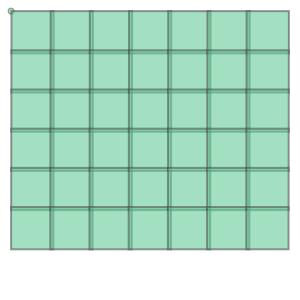

In [178]:
GeometryCollection([origin, 
                    GeometryCollection(shapely_tiles)])

In [165]:
tt = np.array(list_images(meta))
it = np.arange(len(tt))
print(tt[it])

['Roi:1/Tile:0' 'Roi:1/Tile:1' 'Roi:1/Tile:2' 'Roi:1/Tile:3'
 'Roi:1/Tile:4' 'Roi:1/Tile:5' 'Roi:1/Tile:6' 'Roi:1/Tile:7'
 'Roi:1/Tile:8' 'Roi:1/Tile:9' 'Roi:1/Tile:10' 'Roi:1/Tile:11'
 'Roi:1/Tile:12' 'Roi:1/Tile:13' 'Roi:1/Tile:14' 'Roi:1/Tile:15'
 'Roi:1/Tile:16' 'Roi:1/Tile:17' 'Roi:1/Tile:18' 'Roi:1/Tile:19'
 'Roi:1/Tile:20' 'Roi:1/Tile:21' 'Roi:1/Tile:22' 'Roi:1/Tile:23'
 'Roi:1/Tile:24' 'Roi:1/Tile:25' 'Roi:1/Tile:26' 'Roi:1/Tile:27'
 'Roi:1/Tile:28' 'Roi:1/Tile:29' 'Roi:1/Tile:30' 'Roi:1/Tile:31'
 'Roi:1/Tile:32' 'Roi:1/Tile:33' 'Roi:1/Tile:34' 'Roi:1/Tile:35'
 'Roi:1/Tile:36' 'Roi:1/Tile:37' 'Roi:1/Tile:38' 'Roi:1/Tile:39'
 'Roi:1/Tile:40' 'Roi:1/Tile:41']


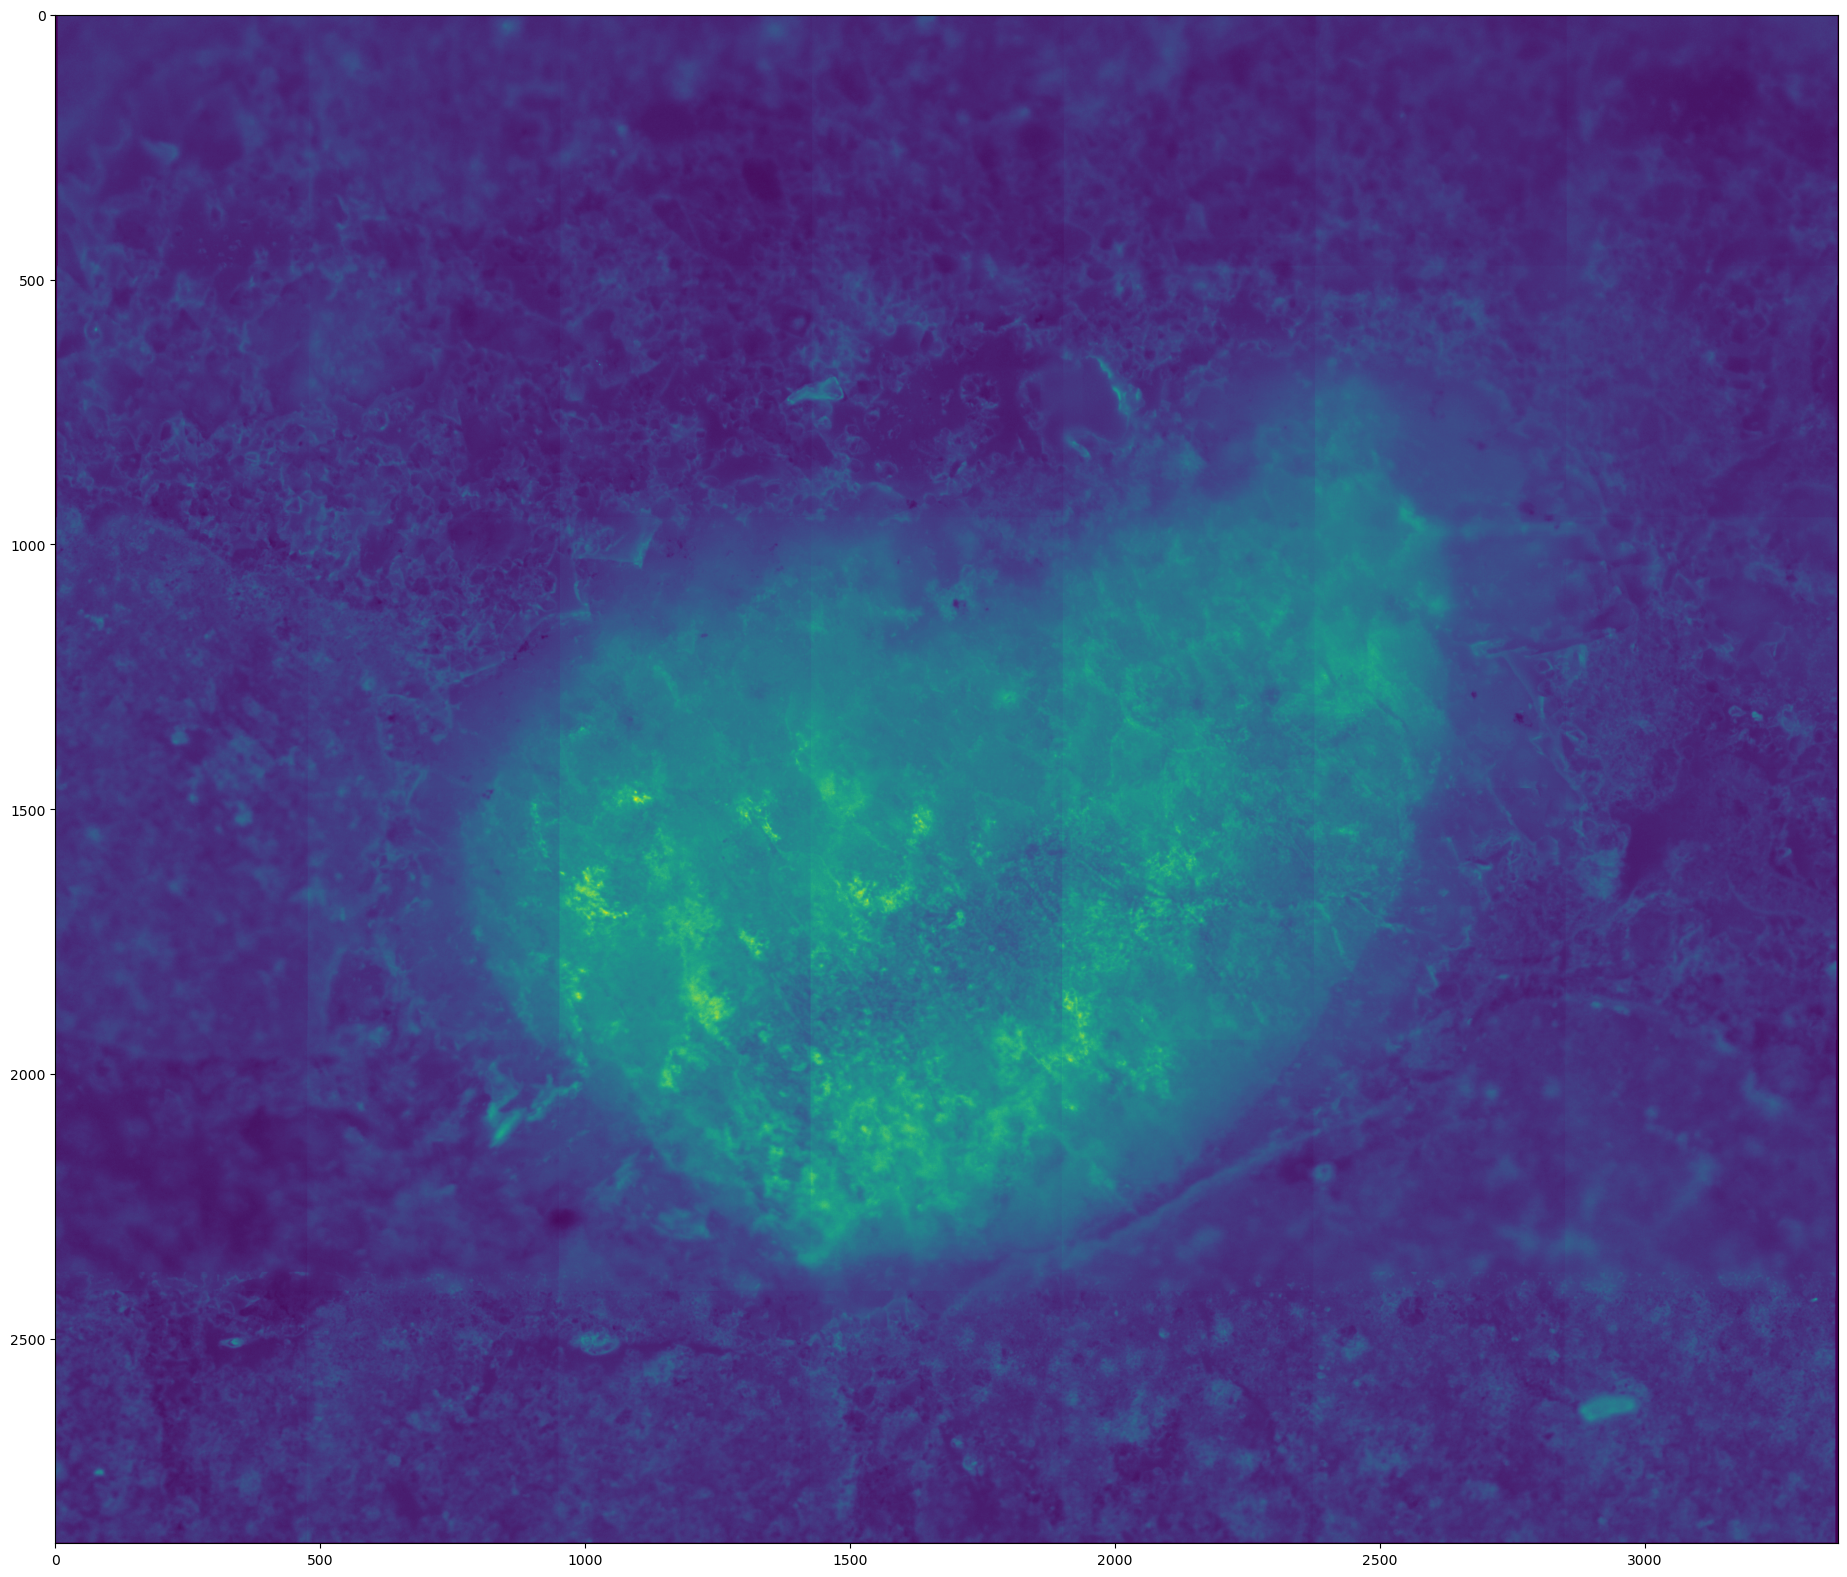

In [129]:

import matplotlib.pyplot as plt

plt.figure(figsize=(23, 23))
plt.imshow(mosaic)

In [ ]:
all_cdf = []
all_gray = []
for t in tiles_infos:
    #histo = np.histogram(t['lazy_image'], bins=500)
    x, counts = np.unique(t['lazy_image'].ravel(), return_counts=True)
    tmpcum = np.cumsum(counts)
    all_cdf += [tmpcum/tmpcum[-1]]
    all_gray += [x]
    plt.plot(x, all_cdf[-1])
    
# Interpolation
xint = np.linspace(0, np.max([np.max(m) for m in all_gray]), 500)
all_interp_cdf = []
for i, cdf in enumerate(all_cdf):
    interp_cdf = np.interp(xint, all_gray[i], cdf, left=0, right=1)
    all_interp_cdf += [interp_cdf]
    plt.plot(xint[::10], interp_cdf[::10], 'k.')
    
all_cdf = np.stack(all_interp_cdf)

In [ ]:
from sklearn import preprocessing
from sklearn import decomposition

In [ ]:
all_cdf_normed = preprocessing.normalize(all_cdf, axis=1)

In [ ]:
_ = plt.plot(xint, all_cdf.T)
plt.plot(xint, np.median(all_cdf, axis=0), 'k-', lw=5)

In [ ]:
pix_int = np.interp()

In [ ]:
# Remove the Mean do the PCA
X = (all_cdf_normed).T
PCA = decomposition.PCA(n_components=10)
model = PCA.fit(X)
transformed_X = PCA.transform(X)

In [ ]:
plt.plot(np.cumsum(model.explained_variance_ratio_), 'ro')
plt.ylabel('Variance')
plt.xlabel('PC')

In [ ]:
plt.plot(model.components_[0], model.components_[1], '+')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
plt.plot(transformed_X)